In [ ]:
import torch
import torch.nn as nn

class GaussianRBFNetworkC(nn.Module):
    def __init__(self, gaussian_regularizer, centers_regularizer, weights_regularizer, learnable_centers,
                 centers, device='cuda'):
        super(GaussianRBFNetworkC, self).__init__()

        self.device = device
        self.gaussian_regularizer = gaussian_regularizer
        self.centers_regularizer = centers_regularizer
        self.weights_regularizer = weights_regularizer
        self.centers = centers
        self.learnable_centers = learnable_centers
        self.n_centers = centers.shape[0]
        self.n_features = centers.shape[1]
        # Define learnable parameters
        self.precision_elements = nn.Parameter(torch.randn(self.n_features * (self.n_features + 1) // 2)
                                               .to(self.device))
        if self.learnable_centers == True:
            self.centers = nn.Parameter(centers.to(self.device))
        else:
            self.centers_regularizer = 1e-32
        self.weights = nn.Parameter(torch.randn(self.n_centers)
                                    .to(self.device))

    def compute_precision(self, precision_elements):

        lower_tri = torch.zeros((self.n_features, self.n_features)).to(self.device)
        idx = torch.tril_indices(*lower_tri.shape)
        lower_tri[idx[0], idx[1]] = precision_elements
        precision_matrix = torch.matmul(lower_tri, lower_tri.T)
        return precision_matrix

    def forward(self, X):

        precision_matrix = self.compute_precision(self.precision_elements)
        diff = X[:, None, :] - self.centers.unsqueeze(0)



        Phi = torch.exp(-0.5 * torch.einsum('ijk, kl, ijl -> ij', diff, precision_matrix, diff))

        #self.bn = nn.BatchNorm1d(Phi)  # Initialize BatchNorm1d layer
        #y_hat = torch.relu(torch.batch_norm(input= Phi , weights= self.weights,bias=None,running_mean=None,running_var=None,training=False,momentum=0.001,eps=0.0000001,cudnn_enabled=False))
        '''y_hat = torch.relu(torch.nn.functional.batch_norm(input=Phi, running_mean=torch.zeros(Phi.shape[1], device=self.device),
                                                         running_var=torch.ones(Phi.shape[1], device=self.device),
                                                          weight=self.weights,bias=None, training=False, momentum=0.1, eps=1e-05)) # shape (batch_size,)'''
        '''variance=X.var(dim=0)
        diff=diff/variance
        y_hat = torch.relu(torch.nn.functional.batch_norm(input=Phi, running_mean=diff,
                                                         running_var=variance[None,:],
                                                          weight=self.weights,bias=None, training=False, momentum=0.1, eps=1e-05)) # shape (batch_size,)'''

        y_hat = torch.sigmoid(Phi @ self.weights)
        return y_hat

    def evaluate_loss(self, y, y_hat):

        bce_loss = nn.BCELoss()
        loss = bce_loss(y_hat, y)
        reg_gaussian = self.gaussian_regularizer * torch.linalg.norm(self.precision_elements)
        reg_centers = self.centers_regularizer * torch.linalg.norm(self.centers)
        reg_weights = self.weights_regularizer * torch.linalg.norm(self.weights)
        loss = loss + reg_gaussian + reg_centers + reg_weights
        return loss

    def feature_importance(self, precision_matrix):

        eigenvalues, eigenvectors = torch.linalg.eigh(precision_matrix)
        feature_importance = torch.matmul(torch.abs(eigenvectors), eigenvalues)
        return feature_importance / torch.sum(feature_importance), eigenvalues, eigenvectors

In [ ]:
# Import necessary libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Load the heart attack dataset
data = pd.read_csv('covid_19.csv')

# Preview the dataset
print(data.head())

# Assume the target variable is named 'output' (1 for heart attack, 0 for no heart attack)
# Adjust feature columns based on your dataset
X = data.drop(columns=['Covid_test_result'])#['output'])  # Features
y = data['Covid_test_result']#['output']  # Target variable

# Convert to numpy arrays
X = X.to_numpy() #values
y = y.to_numpy()#values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_st = torch.tensor(X_train_st, dtype=torch.float32)
X_test_st = torch.tensor(X_test_st, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Check the shapes of the tensors
print(X_train_st.shape, y_train.shape)
print(X_test_st.shape, y_test.shape)

   Ind_ID  Cough_symptoms  Fever  Sore_throat  Shortness_of_breath  Headache  \
0       1               1      0            1                    0         0   
1       2               0      1            0                    0         0   
2       3               0      1            0                    0         0   
3       4               1      0            0                    0         0   
4       5               1      0            0                    0         0   

   Known_contact  Test Date  Covid_test_result  
0              1       2020                  0  
1              1       2020                  1  
2              1       2020                  1  
3              1       2020                  0  
4              2       2020                  0  
torch.Size([3961, 8]) torch.Size([3961])
torch.Size([1698, 8]) torch.Size([1698])


In [ ]:
import torch
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

# Step 1: Define parameters
n_centers =16   # Number of RBF centers
gamma = 0.1    # Gamma for the RBF kernel
learnable_centers = True
gaussian_reg, centers_reg, weights_reg = 1e-2, None, 1e-5

# Step 2: Compute RBF affinity matrix
affinity_matrix = rbf_kernel(X_train_st, gamma=gamma)

# Step 3: Perform Spectral Clustering to get cluster labels
spectral_clustering = SpectralClustering(n_clusters=n_centers, affinity='rbf',gamma=gamma/10, assign_labels='kmeans')#,n_components=X_train_st.shape[1])
labels = spectral_clustering.fit_predict(affinity_matrix)

# Step 4: Calculate centers as the mean of points in each cluster
centers = []
for i in range(n_centers):
    cluster_points = X_train_st[labels == i]
    center = cluster_points.mean(axis=0)
    centers.append(center)

centers = torch.tensor(np.array(centers), dtype=torch.float32)

# 'centers' now contains the RBF centers determined via Spectral Clustering


In [ ]:
# Define regularization parameters
gaussian_reg = 0.01  # Example regularization weight for Gaussian width
centers_reg = 0.01   # Example regularization weight for centers
weights_reg = 0.01   # Example regularization weight for weights
learnable_centers = False  # Set to True if the centers are trainable
#centers = torch.rand(10, X_train_st.shape[1])  # Example initialization with 10 centers
# Calculate the centers (mean of points in each cluster based on labels)
centers = np.array([X_train_st[labels == i].mean(axis=0) for i in range(n_centers)])
centers = torch.tensor(centers, dtype=torch.float32)
print(centers.shape)

torch.Size([16, 8])


In [ ]:
for i in range(n_centers):
    points_in_cluster = X_train_st[labels == i]  # Points assigned to this cluster
    print(f"Center {i} (label {i}) has {len(points_in_cluster)} points:")
    print(points_in_cluster)
    print(f"Cluster Center {i}: {centers[i]}\n")


Center 0 (label 0) has 2619 points:
tensor([[ 0.7340, -0.4809, -0.3620,  ..., -0.1322,  0.4807,  0.0000],
        [ 1.0963, -0.4809, -0.3620,  ..., -0.1322,  0.4807,  0.0000],
        [ 1.4452, -0.4809, -0.3620,  ..., -0.1322,  0.4807,  0.0000],
        ...,
        [ 0.2672, -0.4809, -0.3620,  ..., -0.1322,  0.4807,  0.0000],
        [-0.1343, -0.4809, -0.3620,  ..., -0.1322,  0.4807,  0.0000],
        [-0.0579, -0.4809, -0.3620,  ..., -0.1322,  0.4807,  0.0000]])
Cluster Center 0: tensor([ 0.3928, -0.4760, -0.3608, -0.2226, -0.2431, -0.1322,  0.4654,  0.0000])

Center 1 (label 1) has 56 points:
tensor([[-0.9598,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322,  0.4807,  0.0000],
        [-0.5834,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322,  0.4807,  0.0000],
        [-0.8131,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322,  0.4807,  0.0000],
        [-1.6074,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322,  0.4807,  0.0000],
        [-1.1742,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322,  0.48

In [ ]:
# Assuming `centers` is your tensor of cluster centers and `labels` is the array of labels
for i in range(n_centers):
    print(f"Center {i} (label {i}): {centers[i]}")


Center 0 (label 0): tensor([ 0.3928, -0.4760, -0.3608, -0.2226, -0.2431, -0.1322,  0.4654,  0.0000])
Center 1 (label 1): tensor([-0.9536,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322,  0.4807,  0.0000])
Center 2 (label 2): tensor([ 0.9072,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322,  0.4807,  0.0000])
Center 3 (label 3): tensor([ 0.6639, -0.4809, -0.3620, -0.2226, -0.2431, -0.1322, -2.3803,  0.0000])
Center 4 (label 4): tensor([-1.0398,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322, -0.9498,  0.0000])
Center 5 (label 5): tensor([-0.2634, -0.4809,  2.7622, -0.2226, -0.2431, -0.1322,  0.1088,  0.0000])
Center 6 (label 6): tensor([-0.4379,  2.0794,  2.7622, -0.2226, -0.2431, -0.1322, -0.0293,  0.0000])
Center 7 (label 7): tensor([-0.8385,  2.0794, -0.3620, -0.2226, -0.2431, -0.1322, -2.3803,  0.0000])
Center 8 (label 8): tensor([-0.4073,  1.0553,  1.9893,  1.9860,  1.8207,  2.6231, -1.0627,  0.0000])
Center 9 (label 9): tensor([-0.6777,  0.7699, -0.3620, -0.2226,  4.1138, -0.1322, -0.8624, 

In [ ]:

batch_size = 256
step_size = 0.01  #learning rate
model = GaussianRBFNetworkC(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg,
                            weights_regularizer=weights_reg, learnable_centers=learnable_centers, centers=centers,
                            device='cpu')

# Create data loaders
train_dataset = TensorDataset(X_train_st, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Training settings
optimizer = optim.Adam(model.parameters(), lr=step_size)

##replace  with GCADAM
n_epochs = 5000

# Training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_hat = model(batch_X)
        loss = model.evaluate_loss(batch_y, y_hat)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')

Epoch 0, Loss: 0.4673652835190296
Epoch 50, Loss: 0.2860659407451749
Epoch 100, Loss: 0.2871686341241002
Epoch 150, Loss: 0.2835268145427108
Epoch 200, Loss: 0.28165720496326685
Epoch 250, Loss: 0.28375623282045126
Epoch 300, Loss: 0.2858175691217184
Epoch 350, Loss: 0.28448023833334446
Epoch 400, Loss: 0.28419563360512257
Epoch 450, Loss: 0.28600180614739656
Epoch 500, Loss: 0.2842000322416425
Epoch 550, Loss: 0.2830131473019719
Epoch 600, Loss: 0.28736771363765
Epoch 650, Loss: 0.28519605938345194
Epoch 700, Loss: 0.2861156901344657
Epoch 750, Loss: 0.286479938775301
Epoch 800, Loss: 0.285069290548563
Epoch 850, Loss: 0.28678058460354805
Epoch 900, Loss: 0.2864193795248866
Epoch 950, Loss: 0.28359468560665846
Epoch 1000, Loss: 0.2872171113267541
Epoch 1050, Loss: 0.2847030144184828
Epoch 1100, Loss: 0.2851061914116144
Epoch 1150, Loss: 0.2859625443816185
Epoch 1200, Loss: 0.2853897288441658
Epoch 1250, Loss: 0.285755043849349
Epoch 1300, Loss: 0.28531982190907
Epoch 1350, Loss: 0.283

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_st).numpy() > 0.5
    y_test_pred = model(X_test_st).numpy() > 0.5

# Convert y_train and y_test to NumPy arrays before using accuracy_score
train_accuracy = accuracy_score(y_train.numpy(), y_train_pred) # Changed line
test_accuracy = accuracy_score(y_test.numpy(), y_test_pred)   # Changed line

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: 0.9045695531431457
Test Accuracy: 0.9040047114252061


In [ ]:
# Evaluate the model
#model.eval()
#with torch.no_grad():
    #y_train_pred = np.round(model(X_train_st).numpy(),1)>=0.5 #0.4#0.5
    #y_test_pred = np.round (model(X_test_st).numpy(),1) >=0.5#0.4# 0.5
    #y_train_pred = model(X_train_st).numpy()>0.5 #0.4#0.5
    #y_test_pred = model(X_test_st).numpy() >0.5#0.4# 0.5

#train_accuracy = accuracy_score(y_train, y_train_pred)
#test_accuracy = accuracy_score(y_test, y_test_pred)

#print(f'Train Accuracy: {train_accuracy}')
#print(f'Test Accuracy: {test_accuracy}')

In [ ]:
# Extract feature importance
precision_matrix = model.compute_precision(model.precision_elements)
feature_importance1, eigenvalues, eigenvectors = model.feature_importance(precision_matrix)

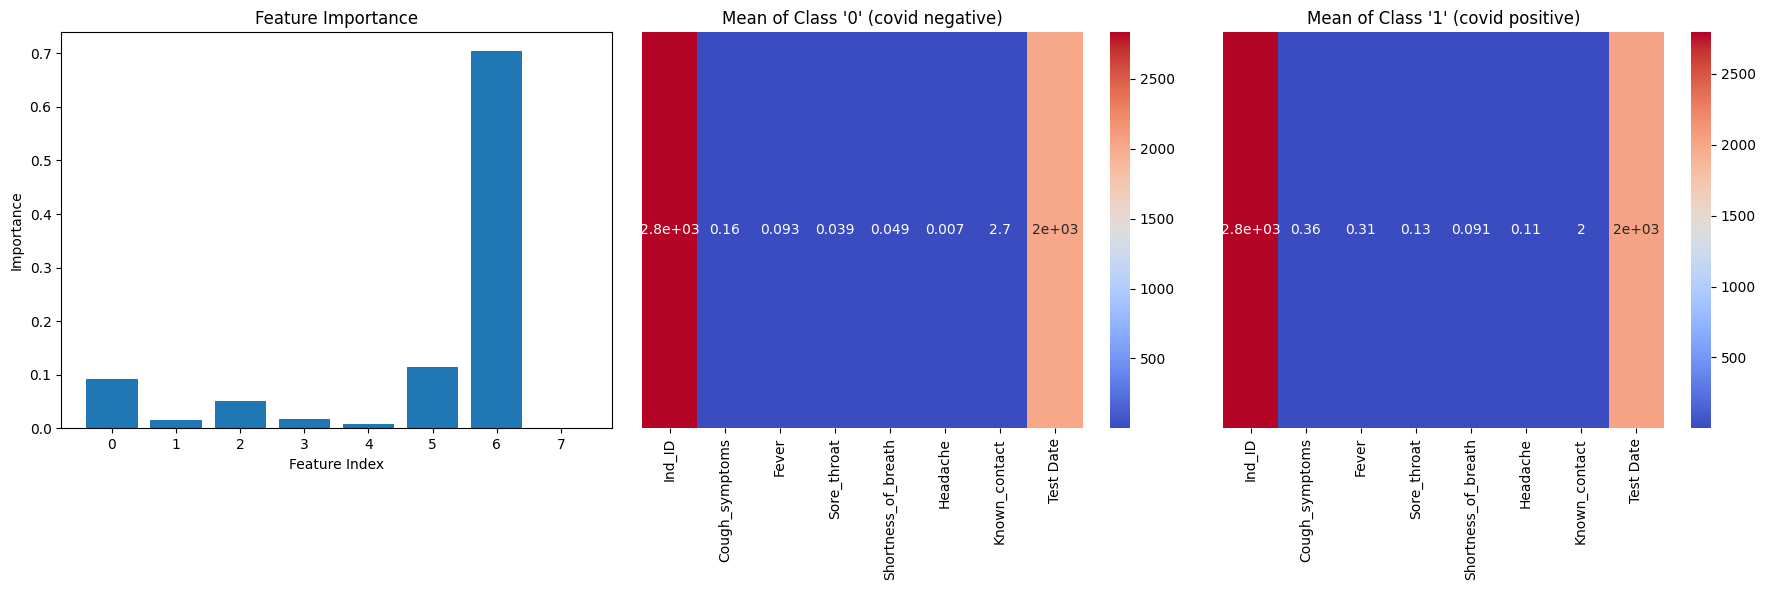

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Example feature_importance (assuming it is a torch tensor from your model)
# You need to replace this with actual feature importance from your model
#feature_importance = torch.rand(13)  # Assuming 13 features in the heart dataset

# Detach if required and convert to numpy array
feature_importance = feature_importance1.detach().numpy()

# Assuming X is the feature matrix and y is the target
# Replace X and y with actual data from your heart dataset
# For example, X_train, y_train from the split step
mean_no_disease = X[y == 0].mean(axis=0)  # Mean of class '0' (no heart disease)
mean_disease = X[y == 1].mean(axis=0)     # Mean of class '1' (heart disease)

# Plot the feature importance and class means
plt.figure(figsize=(18, 6))

# Plot 1: Feature Importance as a bar plot
plt.subplot(1, 3, 1)
plt.title("Feature Importance")
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(np.arange(len(feature_importance)))

# Plot 2: Mean of Class '0' (No Heart Disease) as a heatmap
plt.subplot(1, 3, 2)
plt.title("Mean of Class '0' (covid negative)")
sns.heatmap(mean_no_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=data.columns[:-1])
plt.yticks([])

# Plot 3: Mean of Class '1' (Heart Disease) as a heatmap
plt.subplot(1, 3, 3)
plt.title("Mean of Class '1' (covid positive)")
sns.heatmap(mean_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=data.columns[:-1])
plt.yticks([])

# Show the plots
plt.tight_layout()
plt.show()


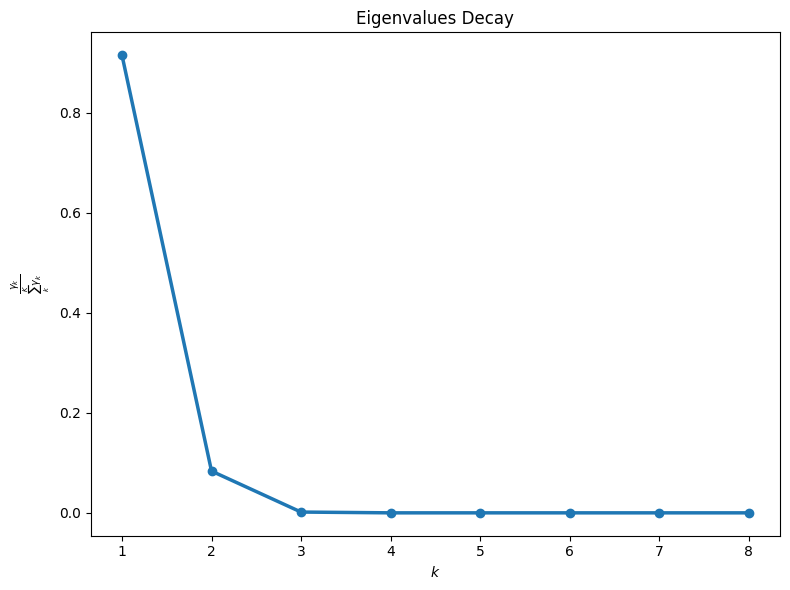

In [ ]:
# Plot eigenvalues decay
gammas = eigenvalues.detach().numpy()[::-1] # sort eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(gammas) + 1), gammas / np.sum(gammas), marker='o', linestyle='-' , linewidth=2.5)
plt.xlabel('$k$')
plt.title("Eigenvalues Decay")
plt.ylabel(r'$\frac{\gamma_k}{\sum_k^K \gamma_k}$')
plt.tight_layout()
plt.show()

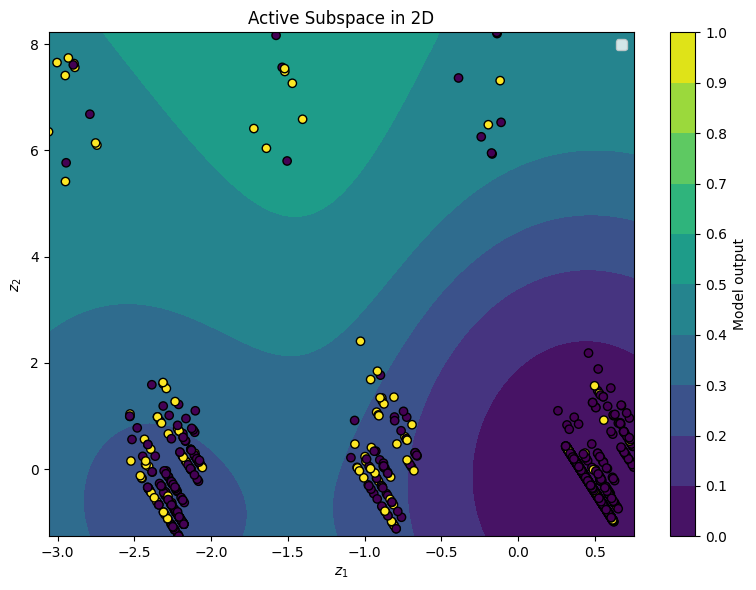

In [ ]:
# Plot contours

V = eigenvectors.detach().numpy()[:, ::-1] # sort eigenvectors
Z = np.dot(X_test_st, V[:, :2]) # project data into the latent or active subspace defined by the top-2 eigenvectors

lb1, ub1 = min(Z[:, 0]), max(Z[:, 0])
lb2, ub2 = min(Z[:, 1]), max(Z[:, 1])
xx1 = np.linspace(lb1, ub1, 100)
xx2 = np.linspace(lb2, ub2, 100)

XX1, XX2 = np.meshgrid(xx1, xx2)
xx12 = np.vstack([XX1.ravel(), XX2.ravel()]).T
xx12_back = np.dot(xx12, V[:, :2].T) # reproject back data from the active subspace so that we can evaluate the model
xx12_back = torch.tensor(xx12_back, dtype=torch.float32)

#XX3 = (np.round(model(xx12_back).detach().numpy(),1)).reshape(XX1.shape) # obtan the model output
XX3 = model(xx12_back).detach().numpy().reshape(XX1.shape) # obtan the model output

fig, ax = plt.subplots(figsize=(8, 6))
# Plot centers
centers_projected = np.dot(model.centers.detach().numpy(), V[:, :2])

contours = plt.contourf(XX1, XX2, XX3, cmap='viridis', levels=np.linspace(0, 1, 11))
cbar = plt.colorbar(contours)
cbar.set_label('Model output')
cbar.set_ticks(np.linspace(0, 1, 11))

plt.scatter(Z[:, 0], Z[:, 1], c=y_test, edgecolors='black')
#plt.scatter(centers_projected[:, 0], centers_projected[:, 1], c='red', marker='x', label='Centers')

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.title('Active Subspace in 2D')
plt.legend()
plt.tight_layout()